In [173]:
# LP approach to DP

# open opt setting

% matplotlib inline
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
import time
from openopt import LP
import quantecon as qe
from quantecon.markov.ddp import DPSolveResult

class SimpleOG(object):

    def __init__(self, B=10, M=5, alpha=0.5, beta=0.9):

        self.B, self.M, self.alpha, self.beta  = B, M, alpha, beta
        self.n = B + M + 1
        self.m = M + 1

        self.R = np.empty((self.n, self.m))
        self.Q = np.zeros((self.n, self.m, self.n))

        self.populate_Q()
        self.populate_R()

    def u(self, c):
        return c**self.alpha

    def populate_R(self):

        for s in range(self.n):
            for a in range(self.m):
                self.R[s, a] = self.u(s - a) if a <= s else -np.inf

    def populate_Q(self):

        for a in range(self.m):
            self.Q[:, a, a:(a + self.B + 1)] = 1.0 / (self.B + 1)


# solve by linear programming open opt setting
def LP_approach(setting):
    n = setting.num_states
    m = setting.num_actions
    
    f = np.ones(n)
    
    d = setting.beta * setting.Q
    d[np.arange(n), :, np.arange(n)] -= 1
    A = d.reshape((n*m, n))
    
    b = setting.R.reshape((n * m, 1)) 
    
    lb = np.zeros(n)
    
    p = LP(f, A=A, b=-b, lb = lb)
    
    r = p.minimize('pclp', show = False) 
    
    # sigma
    sigma = setting.compute_greedy(r.xf)
    
    # result
    res = qe.markov.ddp.DPSolveResult(v=r.xf, sigma = sigma,
                            mc=setting.controlled_mc(sigma),
                            method = 'Exact Linear Programming (Open opt setting )',
                            )
    return res
    
# linear programming time
def elapse_LP(setting):
    start = time.time()
    LP_approach(setting)
    return time.time() - start

# value function time
def elapse_value(setting):
    start = time.time()
    setting.solve(method='value_iteration')
    elapsed_time = time.time() - start
    return elapsed_time

# plot time until num_state = n
# B = 10
def plot_graph(n, discount):
    a = [None] * n
    b = [None] * n
    for i in range(11,n):
        ddp = qe.markov.random_discrete_dp(i, 10, discount)
        a[i] = elapse_LP(ddp)
        b[i] = elapse_value(ddp)

    plt.plot(a)
    plt.plot(b)
    
# time changing beta LP
def plot_beta_LP(state, shock, betas):
    n = [None] * len(betas)
    for i, value in enumerate(betas):
        ddp = qe.markov.random_discrete_dp(state, shock, value)
        n[i] = elapse_LP(ddp)
    plt.plot(n)
    
#time changing beta value function
def plot_beta_value(state, shock,betas):
    n = [None] * len(betas)
    for i, value in enumerate(betas):
        model = SimpleOG(B = shock, M = state, beta = value)
        ddp = qe.markov.DiscreteDP(model.R, model.Q, model.beta)
        n[i] = elapse_value(ddp)
    plt.plot(n)

In [174]:
# using the above
ddp2 = qe.markov.random_discrete_dp(3, 2, 0.95)
LP_approach(ddp2)


------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.31 
    1  0.000e+00             -14.08 
istop: 1000
Solver:   Time Elapsed = 0.0 	CPU Time Elapsed = 0.0
objFuncValue: 54.077558 (feasible, MaxResidual = 8.38218e-15)


  sigma: array([0, 1, 0])
 method: 'Exact Linear Programming (Open opt setting )'
     mc: Markov chain with transition matrix 
P = 
[[ 0.14273833  0.13794967  0.719312  ]
 [ 0.27335597  0.320093    0.40655104]
 [ 0.20674527  0.62617614  0.1670786 ]]
      v: array([ 16.72036222,  19.22338913,  18.13380639])

In [154]:
ddp3 = qe.markov.random_discrete_dp(10, 4, 0.95)
LP_approach(ddp3)


------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.53 
    1  0.000e+00             -13.28 
istop: 1000
Solver:   Time Elapsed = 0.32 	CPU Time Elapsed = 0.3
objFuncValue: 250.20964 (feasible, MaxResidual = 5.28466e-14)


  sigma: array([3, 2, 1, 3, 3, 0, 2, 0, 2, 1])
 method: 'Exact Linear Programming (Open opt setting )'
     mc: Markov chain with transition matrix 
P = 
[[  8.10406107e-02   1.22692483e-02   9.05979746e-02   6.73461067e-02
    1.92415796e-01   2.66543231e-01   1.44646786e-01   4.68204932e-03
    5.68687790e-02   8.35894174e-02]
 [  1.09897745e-01   1.37718668e-01   2.07713595e-01   1.11928653e-01
    5.57592903e-02   3.84656788e-02   2.29992705e-01   4.01419226e-02
    3.65006388e-03   6.47316782e-02]
 [  4.87385415e-02   1.86309501e-01   1.68142303e-01   1.18607063e-02
    1.17261661e-03   4.95751085e-03   1.16150528e-01   1.87917643e-01
    4.87187902e-02   2.26031860e-01]
 [  5.45389129e-02   5.78459638e-02   5.42535155e-02   3.16531018e-01
    2.56289755e-02   3.53787963e-02   2.18001364e-01   1.03632043e-01
    2.79014894e-02   1.06287922e-01]
 [  1.13360637e-01   4.72024205e-02   1.12531122e-01   8.90479319e-02
    2.27764602e-02   1.05848083e-01   2.74863582e-01   1.71197129e-0


------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.31 
    1  0.000e+00             -12.98 
istop: 1000
Solver:   Time Elapsed = 0.93 	CPU Time Elapsed = 0.9
objFuncValue: 158.10466 (feasible, MaxResidual = 1.03695e-13)

------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.44 
    1  0.000e+00             -11.83 
istop: 1000
Solver:   Time Elapsed = 0.98 	CPU Time Elapsed = 0.98
objFuncValue: 169.64229 (feasible, MaxResidual = 1.46616e-12)

------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.50 
    1  0.000e+00             -12.89 
istop: 1000
Solver:   T

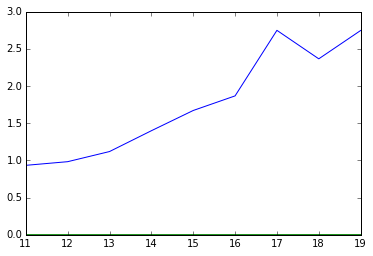

In [175]:
plot_graph(20, 0.9)


------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.43 
    1  0.000e+00             -13.08 
istop: 1000
Solver:   Time Elapsed = 1.21 	CPU Time Elapsed = 1.15
objFuncValue: 295.97437 (feasible, MaxResidual = 8.40439e-14)
0

------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.44 
    1  0.000e+00             -13.29 
istop: 1000
Solver:   Time Elapsed = 1.02 	CPU Time Elapsed = 1.01
objFuncValue: 293.09957 (feasible, MaxResidual = 5.17364e-14)
1

------------------------- OpenOpt 0.5625 -------------------------
problem: unnamed   type: LP    goal: minimum
solver: pclp
  iter  objFunVal  log10(maxResidual)  
    0  0.000e+00               0.33 
    1  0.000e+00             -13.62 
istop: 1000
Solver

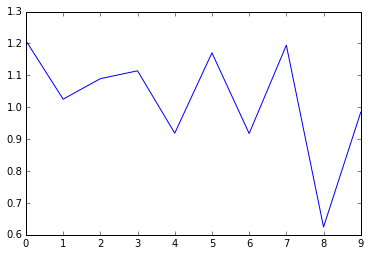

In [170]:
plot_beta_LP(20,5,np.linspace(0.9,0.99,20))

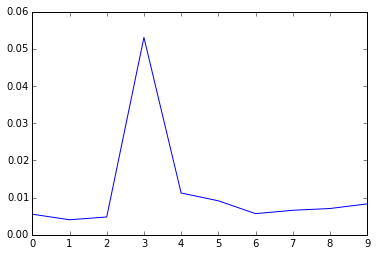

In [172]:
plot_beta_value(20,5, np.linspace(0.9,0.99,20))